In [1]:
from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from torchray_extremal_perturbation_sequence import extremal_perturbation, contrastive_reward, simple_reward
from torchray.utils import get_device

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

class MySequence :
    def __init__(self) :
        self.dummy = 1

import tensorflow as tf

import tensorflow.keras

tf.keras.utils.Sequence = MySequence

from sequence_logo_helper import plot_dna_logo, dna_letter_at


In [2]:
#Load data

dataset_name = "apa_doubledope"

npzfile = np.load(dataset_name + ".npz")

x_train = npzfile['x_train']
y_train = npzfile['y_train']
x_test = npzfile['x_test']
y_test = npzfile['y_test']

#Make binary labels

digit_train = np.copy(y_train[:, 0])
digit_test = np.copy(y_test[:, 0])

y_train = np.zeros((digit_train.shape[0], 2))
y_train[digit_train < 0.5, 0] = 1
y_train[digit_train >= 0.5, 1] = 1

y_test = np.zeros((digit_test.shape[0], 2))
y_test[digit_test < 0.5, 0] = 1
y_test[digit_test >= 0.5, 1] = 1

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 2)
y_test.shape = (1728, 2)


In [3]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [4]:
#Load predictor model

class CNNClassifier(nn.Module) :
    
    def __init__(self, batch_size, lib_index=5, distal_pas=1.) :
        super(CNNClassifier, self).__init__()
        
        lib_inp_numpy = np.zeros((batch_size, 13))
        lib_inp_numpy[:, lib_index] = 1.
        self.lib_inp = Variable(torch.FloatTensor(lib_inp_numpy).to(torch.device('cuda:0')))
        
        d_inp_numpy = np.zeros((batch_size, 1))
        d_inp_numpy[:, 0] = distal_pas
        self.d_inp = Variable(torch.FloatTensor(d_inp_numpy).to(torch.device('cuda:0')))
        
        self.conv1 = nn.Conv2d(4, 96, kernel_size=(1, 8))
        self.maxpool_1 = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(96, 128, kernel_size=(1, 6))
        
        self.fc1 = nn.Linear(in_features=94 * 128 + 1, out_features=256)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=256 + 13, out_features=1)
        
        self.batch_size = batch_size
        self.use_cuda = True if torch.cuda.is_available() else False
        
    def forward(self, x):
        
        #x = x.transpose(1, 2)
        
        x = F.relu(self.conv1(x))
        x = self.maxpool_1(x)
        x = F.relu(self.conv2(x))
        
        x = x.transpose(1, 3)
        x = x.reshape(-1, 94 * 128)
        
        x = torch.cat([x, self.d_inp], dim=1)
        x = F.relu(self.drop1(self.fc1(x)))
        x = torch.cat([x, self.lib_inp], dim=1)
        
        #x = F.sigmoid(self.fc2(x))
        x = self.fc2(x)
        
        #Transform sigmoid logits to 2-input softmax scores
        x = torch.cat([-1 * x, x], axis=1)
        
        return x


model_pytorch = CNNClassifier(batch_size=1, lib_index=4, distal_pas=1.)
_ = model_pytorch.load_state_dict(torch.load("aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd_pytorch.pth"))


In [5]:
#Create pytorch input tensor

x_test_pytorch = Variable(torch.FloatTensor(np.transpose(x_test, (0, 3, 1, 2))))
x_test_pytorch = x_test_pytorch.cuda() if model_pytorch.use_cuda else x_test_pytorch

digit_test = np.array(np.argmax(y_test, axis=1), dtype=np.int)


In [6]:
#Predict using pytorch model
device = get_device()

model_pytorch.to(device)

model_pytorch.eval()

y_pred_pytorch = np.concatenate([model_pytorch(x_test_pytorch[i:i+1]).data.cpu().numpy() for i in range(x_test.shape[0])], axis=0)

digit_pred_test = np.argmax(y_pred_pytorch, axis=-1)

print("Test accuracy = " + str(round(np.sum(digit_test == digit_pred_test) / digit_test.shape[0], 4)))


Test accuracy = 0.9462


In [7]:

device = get_device()

model_pytorch.to(device)
x_test_pytorch = x_test_pytorch.to(device)


In [8]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()

class IdentityEncoder :
    
    def __init__(self, seq_len, channel_map) :
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

#Initialize sequence encoder

seq_length = 205

residue_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

encoder = IdentityEncoder(seq_length, residue_map)


In [9]:
y_pred_pytorch[:10]

array([[ 2.3671951 , -2.3671951 ],
       [ 1.5098474 , -1.5098474 ],
       [-1.2736068 ,  1.2736068 ],
       [ 1.7340195 , -1.7340195 ],
       [ 0.9948401 , -0.9948401 ],
       [-0.7188092 ,  0.7188092 ],
       [-2.5287635 ,  2.5287635 ],
       [-1.6616201 ,  1.6616201 ],
       [-0.3903193 ,  0.3903193 ],
       [-0.60398585,  0.60398585]], dtype=float32)

extremal_perturbation:
- target: 1
- areas: [0.1]
- variant: preserve
- max_iter: 800
- step/sigma: 3, 5
- image size: [1, 4, 1, 205]
- reward function: contrastive_reward
- Perturbation:
  - type: blur
  - num_levels: 8
  - pyramid shape: [8, 4, 1, 205]
- mask resolution:
  torch.Size([1, 1, 1, 69])
[0001/0800] [area:0.10 loss:5.00 reg:-169.67]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


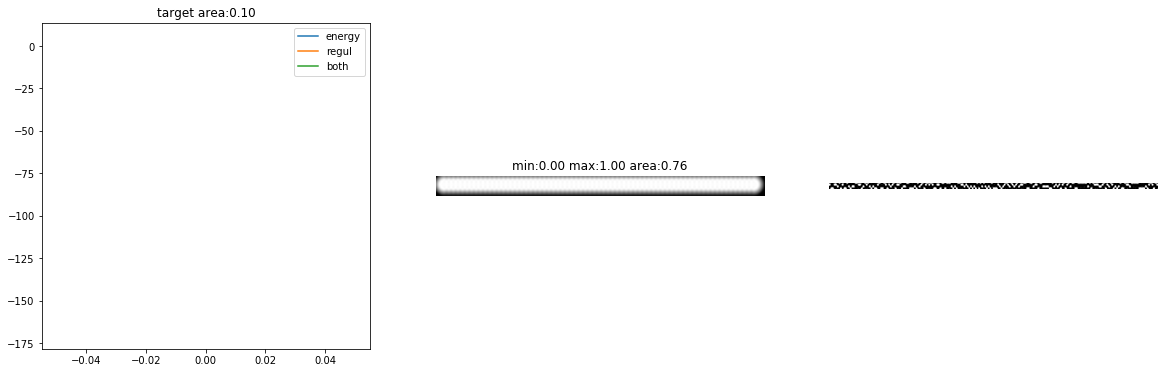

[0200/0800] [area:0.10 loss:-1.14 reg:-7.06]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


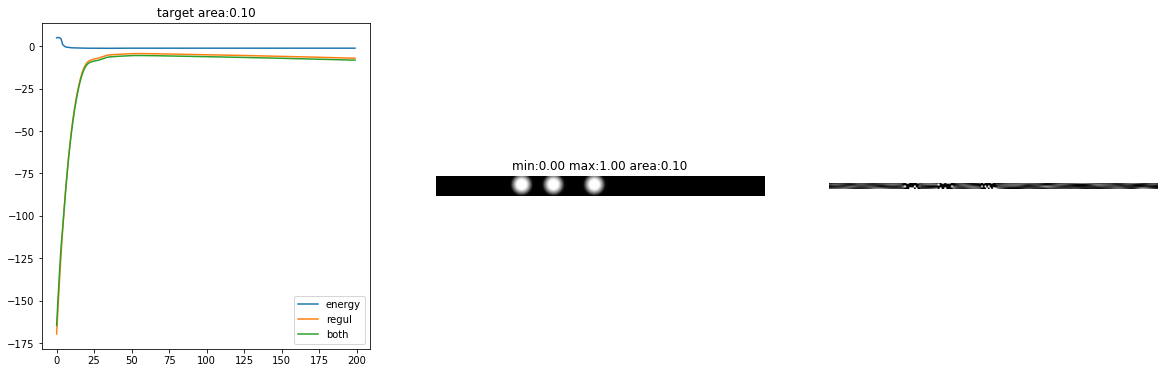

[0399/0800] [area:0.10 loss:-1.14 reg:-14.15]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


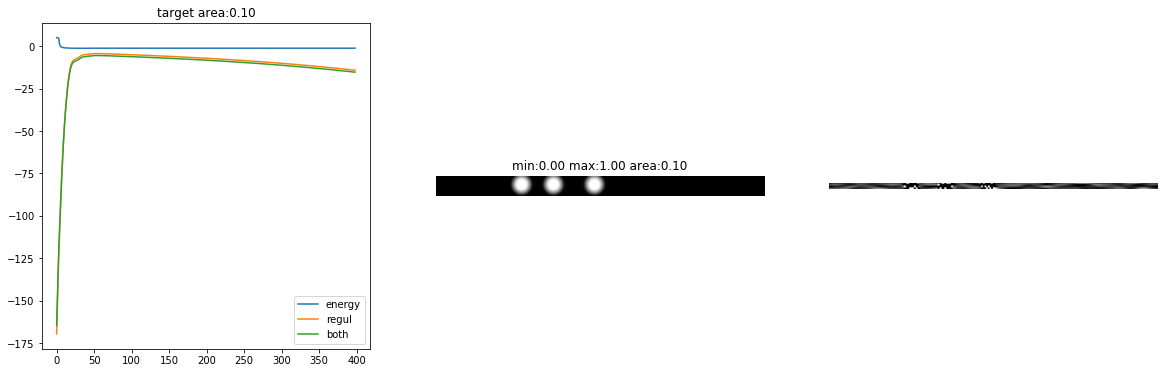

[0598/0800] [area:0.10 loss:-1.14 reg:-28.36]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


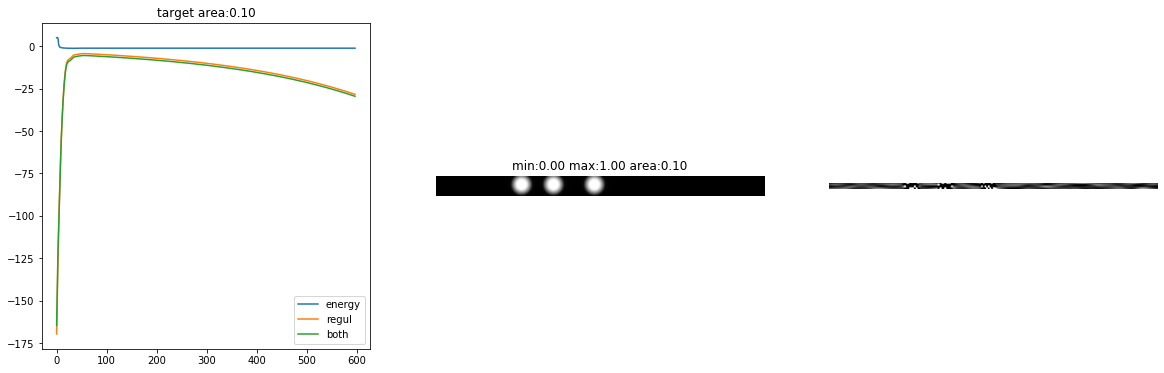

[0797/0800] [area:0.10 loss:-1.14 reg:-56.84]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


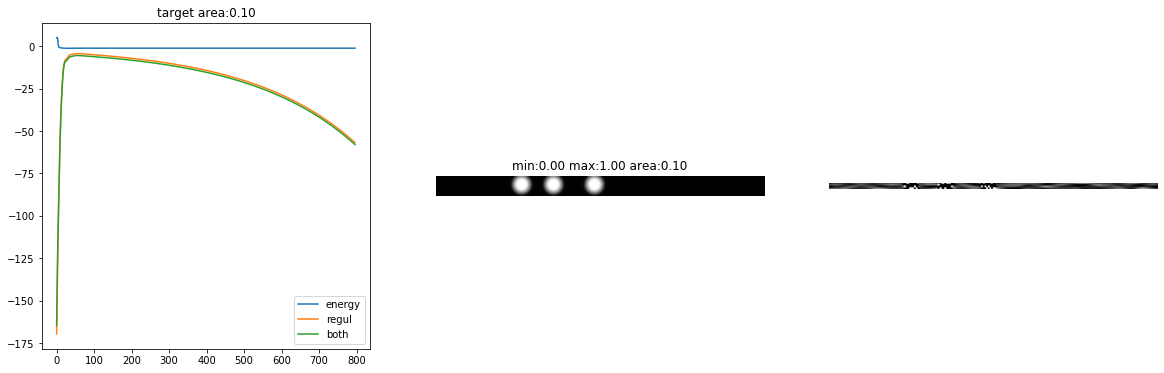

[0800/0800] [area:0.10 loss:-1.14 reg:-57.44]
torch.Size([1, 13, 217])
torch.Size([1, 4, 205])


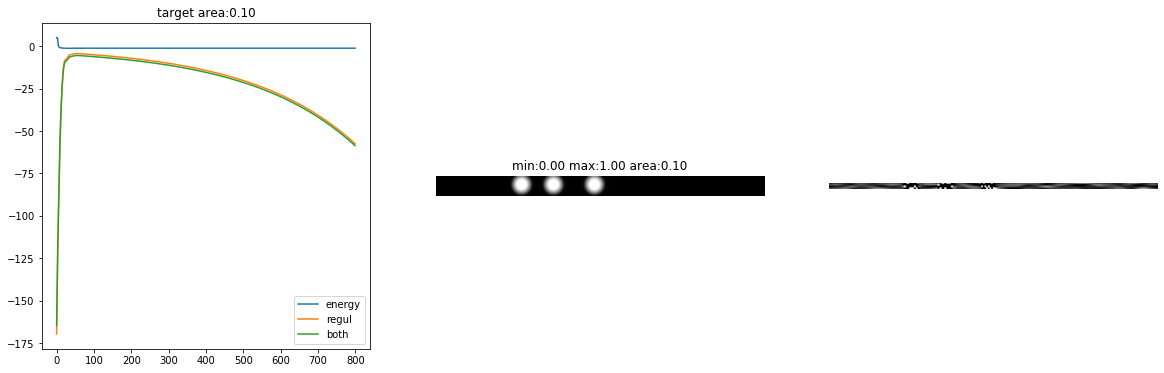

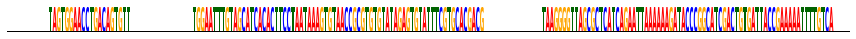

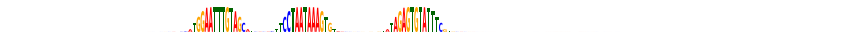

In [11]:
#Execute method on test set

i = 6

area = 0.1
variant_mode = "preserve"
perturbation_mode = "blur"

masks = []

m, _ = extremal_perturbation(
    model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
    reward_func=contrastive_reward,
    debug=True,
    jitter=False,
    areas=[area],
    variant=variant_mode,
    perturbation=perturbation_mode,
    num_levels=8,
    step=3,
    sigma=5
)

imp_s = np.tile(m[0, 0, :, :].cpu().numpy(), (4, 1)) * x_test[i, 0, :, :].T

score_clip = None#0.5

plot_dna_logo(x_test[i, 0, :, :], sequence_template=sequence_template, figsize=(12, 0.65), plot_start=0, plot_end=205)

plot_importance_scores(imp_s, encoder.decode(x_test[i, 0, :, :]), figsize=(12, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)


In [18]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "preserve"
perturbation_mode = "blur"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test sequence 0:


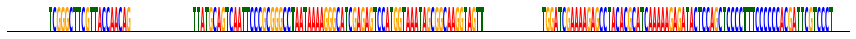

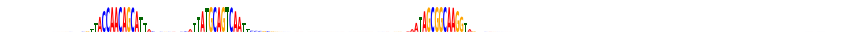

Test sequence 1:


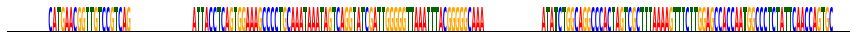

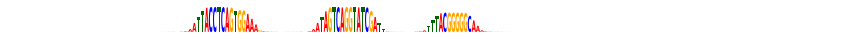

Test sequence 2:


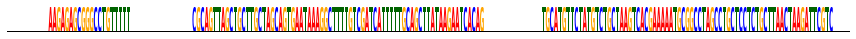

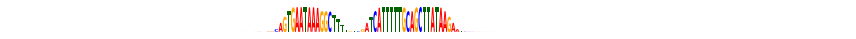

Test sequence 3:


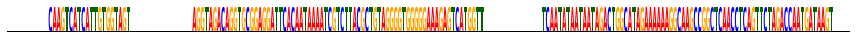

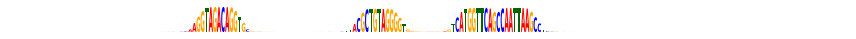

Test sequence 4:


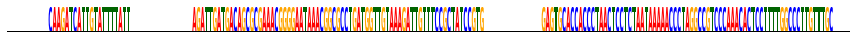

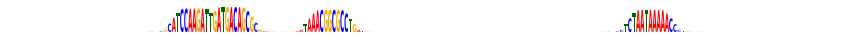

In [19]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None#0.5

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 0.65), plot_start=0, plot_end=205)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)



In [20]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [21]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "preserve"
perturbation_mode = "fade"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test sequence 0:


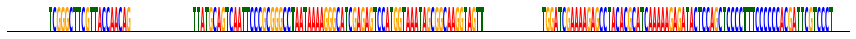

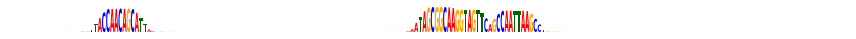

Test sequence 1:


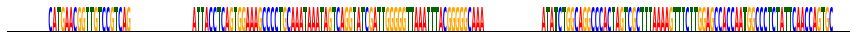

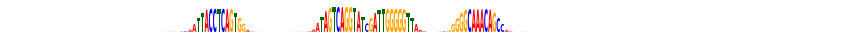

Test sequence 2:


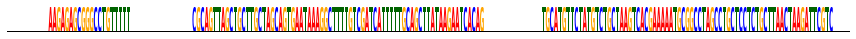

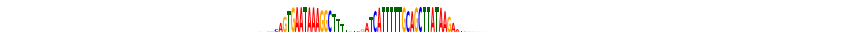

Test sequence 3:


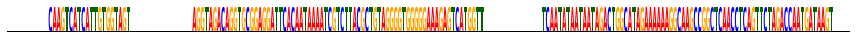

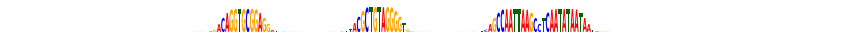

Test sequence 4:


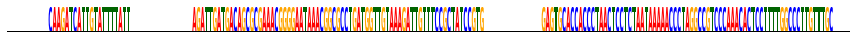

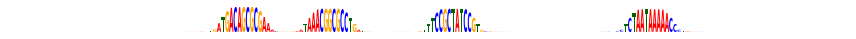

In [22]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None#0.5

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 0.65), plot_start=0, plot_end=205)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)



In [23]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [24]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "delete"
perturbation_mode = "blur"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test sequence 0:


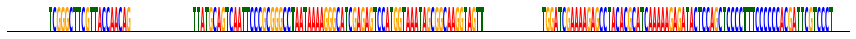

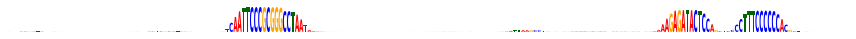

Test sequence 1:


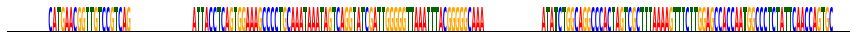

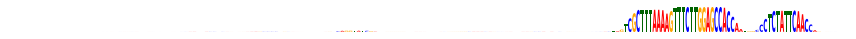

Test sequence 2:


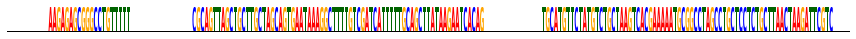

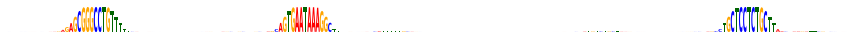

Test sequence 3:


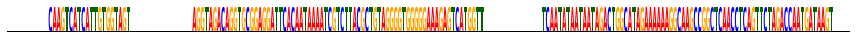

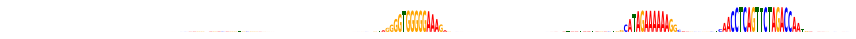

Test sequence 4:


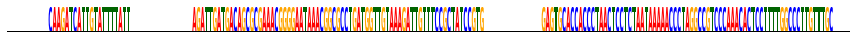

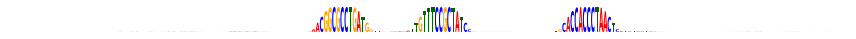

In [25]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None#0.5

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 0.65), plot_start=0, plot_end=205)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)



In [26]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [27]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "delete"
perturbation_mode = "fade"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test sequence 0:


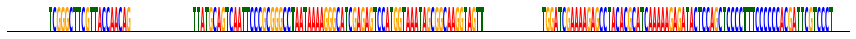

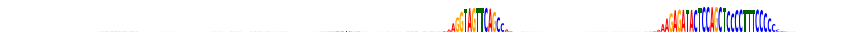

Test sequence 1:


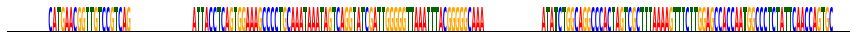

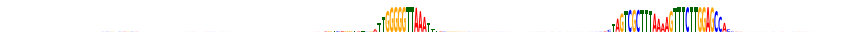

Test sequence 2:


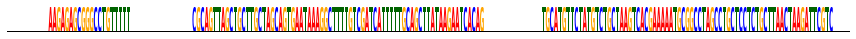

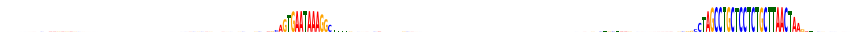

Test sequence 3:


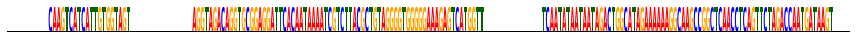

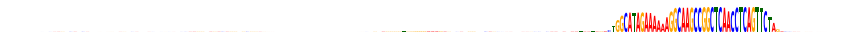

Test sequence 4:


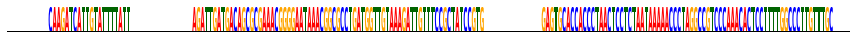

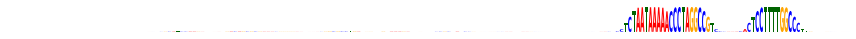

In [28]:
#Visualize a few images

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    imp_s = np.tile(importance_scores_test[plot_i, :, :, 0], (4, 1)) * x_test[plot_i, 0, :, :].T

    score_clip = None#0.5

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 0.65), plot_start=0, plot_end=205)

    plot_importance_scores(imp_s, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205)



In [29]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)
